In [1]:
import openpyxl
import pandas as pd
import numpy as np
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from nbclient.client import timestamp
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Чтение данных из Excel
ticker = 'C_SBER'
file_path = ticker+'.xlsx'
df = pd.read_excel(file_path, skiprows=0
                   , names=['DATE', "CLOSE"])
                   #, names=['TICKER', 'PER', 'DATE', 'TIME', 'CLOSE'])

# Преобразование даты в правильный формат
df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%y')
# Создаем timestamp из даты (время в данных не используется)
df['timestamp'] = df['DATE']

# Создание DataFrame с необходимыми колонками
data = df[
    ['timestamp','CLOSE']
].rename(columns={'CLOSE': 'target'})
data = data.set_index('timestamp')

In [2]:
# Создаем регулярный временной ряд
full_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(full_dates)

# Реиндексация DataFrame на полный диапазон дат и заполнение пропусков
data = data.ffill()

# Подготовка данных в формате AutoGluon
ts_data = data.reset_index()
ts_data.columns = ['timestamp', 'target']
ts_data['item_id'] = ticker  # Для единичного временного ряда

In [3]:
data

,target
2020-01-01,254.961865
2020-01-02,254.961865
2020-01-03,254.961865
2020-01-04,254.961865
2020-01-05,255.177783
...,...
2025-01-28,275.160396
2025-01-29,278.367650
2025-01-30,280.618758
2025-01-31,281.744956


In [4]:
from datetime import datetime, timedelta

def get_date_n_days_ago(date_str, n):
    # Преобразуем строку в объект datetime
    date_format = "%Y-%m-%d"
    date_obj = datetime.strptime(date_str, date_format)

    # Вычитаем N дней
    new_date_obj = date_obj - timedelta(days=n)

    # Преобразуем результат обратно в строку
    new_date_str = new_date_obj.strftime(date_format)

    return new_date_str

In [5]:
# Явное указание частоты
freq = 'D'
N = 31 #Прогноз на N дней
# Разделение на train/test (последние 30 дней - тест)
split_date = '2025-01-01'
shown_date = get_date_n_days_ago(split_date, N)
shown_data = TimeSeriesDataFrame(ts_data[ts_data['timestamp'] >= shown_date])[:2*N]
train_data = TimeSeriesDataFrame(ts_data[ts_data['timestamp'] < split_date])
test_data = TimeSeriesDataFrame(ts_data[ts_data['timestamp'] >= split_date])[:N]

In [7]:
# Инициализация предиктора
predictor = TimeSeriesPredictor(
    target='target',
    prediction_length=N,
    path="autogluon_sber_chronos",
    freq='D'
)

models = ["bolt_base", "bolt_small", "bolt_mini", "bolt_tiny"]

# Обучение с использованием только Chronos
predictor.fit(
    train_data,
    hyperparameters={
            "Chronos": [
                {
                    "model_path": m,
                    "context_length": ln,
                    "num_samples": ln // 3,
                    #"fine_tune": True if m == "bolt_small" and ln == 150 else False,
                    "ag_args": {"name_suffix": "Chronos_"+str(m)+"_"+str(ln)}
                } for ln in (720, 548, 365, 200, 150, 100) for m in models
                # {
                #     "model_path": "bolt_base",
                #     "fine_tune": True,
                #     "ag_args": {"name_suffix": "FineTuned"},
                #     "context_length": 365,  # Количество дней в контексте
                #     "num_samples": 200     # Количество сэмплов для прогноза
                # },
            ],
        },
    #time_limit=120
)
# Прогнозирование
predictions = predictor.predict(train_data)

Beginning AutoGluon training...
AutoGluon will save models to 'C:\Smak\Programming\PyCharm\Forecasting\autogluon_sber_chronos'
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.13.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22000
CPU Count:          16
Pytorch Version:    2.9.1+cu130
CUDA Version:       13.0
GPU Memory:         GPU 0: 8.00/8.00 GB
Total GPU Memory:   Free: 8.00 GB, Allocated: 0.00 GB, Total: 8.00 GB
GPU Count:          1
Memory Avail:       3.03 GB / 15.88 GB (19.1%)
Disk Space Avail:   159.75 GB / 952.62 GB (16.8%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': [{'ag_args': {'name_suffix': 'Chronos_bolt_base_720'},
                                  'context_length': 720,
                                  'model_path': 'bolt_base',
                                  'num_samples': 240},
                            

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/821M [00:00<?, ?B/s]

	-0.0500       = Validation score (-WQL)
	3.93    s     = Training runtime
	333.52  s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_small_720[bolt_small]. 


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]

	-0.0665       = Validation score (-WQL)
	0.01    s     = Training runtime
	22.18   s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_mini_720[bolt_mini]. 


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/85.0M [00:00<?, ?B/s]

	-0.0515       = Validation score (-WQL)
	0.01    s     = Training runtime
	11.30   s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_tiny_720[bolt_tiny]. 


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/34.6M [00:00<?, ?B/s]

	-0.0495       = Validation score (-WQL)
	0.01    s     = Training runtime
	6.12    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_base_548[bolt_base]. 
	-0.0504       = Validation score (-WQL)
	0.01    s     = Training runtime
	1.90    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_small_548[bolt_small]. 
	-0.0590       = Validation score (-WQL)
	0.01    s     = Training runtime
	1.18    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_mini_548[bolt_mini]. 
	-0.0528       = Validation score (-WQL)
	0.01    s     = Training runtime
	1.02    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_tiny_548[bolt_tiny]. 
	-0.0475       = Validation score (-WQL)
	0.01    s     = Training runtime
	1.02    s     = Validation (prediction) runtime
Training timeseries model ChronosChronos_bolt_base_365[bolt_base]. 
	-0.0515       = Validation score (-WQ

In [8]:
# Получение предсказаний в правильном формате
forecast = predictions
predicted_values = forecast['mean']
# Фактические значения для сравнения
actual_values = test_data['target'].values[:len(predicted_values)]
shown_values = shown_data['target'].values
# Извлекаем временные метки из индекса
test_timestamps = test_data.index.get_level_values('timestamp')[:len(predicted_values)]
shown_timestamps = shown_data.index.get_level_values('timestamp')

In [9]:
forecast

mean         0.1         0.2         0.3  \
item_id timestamp                                                    
C_SBER  2025-01-01  279.104370  271.937653  275.061737  276.788086   
        2025-01-02  279.494690  270.530518  274.553101  276.654205   
        2025-01-03  280.550507  269.896545  274.598816  277.135742   
        2025-01-04  281.295471  269.111816  274.410339  277.339752   
        2025-01-05  281.189148  267.526611  273.422363  276.702881   
        2025-01-06  280.479584  265.568542  271.906036  275.558228   
        2025-01-07  280.084808  263.826874  270.531433  274.572968   
        2025-01-08  280.023529  262.293060  269.658447  273.989471   
        2025-01-09  279.651428  261.001923  268.670135  273.328796   
        2025-01-10  279.245544  259.664856  267.746307  272.610138   
        2025-01-11  279.040405  258.481384  266.951782  272.014160   
        2025-01-12  278.882874  257.143982  266.058319  271.349304   
        2025-01-13  278.754486  255.872116  265.148865  270.812744   
        2025-01-14  279.037659  255.043137  264.826263  270.725739   
        2025-01-15  279.377594  254.701874  264.725220  270.751465   
        2025-01-16  279.502167  254.401291  264.554016  270.774109   
        2025-01-17  280.093475  254.359085  264.838654  271.204010   
        2025-01-18  280.793182  254.630310  265.176086  271.664429   
        2025-01-19  281.223175  254.624634  265.486176  272.004700   
        2025-01-20  281.410919  254.042801  265.216095  271.906067   
        2025-01-21  280.966309  253.104980  264.458588  271.199127   
        2025-01-22  280.538635  252.183228  263.677765  270.561768   
        2025-01-23  280.708862  251.572617  263.256104  270.400421   
        2025-01-24  280.900909  251.196686  263.125427  270.433960   
        2025-01-25  280.939240  250.867889  262.814667  270.302185   
        2025-01-26  281.248016  250.416916  262.709991  270.279480   
        2025-01-27  281.525452  250.020050  262.556885  270.287750   
        2025-01-28  281.445038  248.992569  261.721527  269.728363   
        2025-01-29  280.651489  247.579391  260.371429  268.538391   
        2025-01-30  279.691650  246.097412  258.917053  267.334503   
        2025-01-31  279.117889  244.910248  257.890839  266.375397   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
C_SBER  2025-01-01  278.059418  279.104370  280.085449  281.121429   
        2025-01-02  278.208313  279.494690  280.750671  282.077850   
        2025-01-03  279.029541  280.550507  282.009033  283.734314   
        2025-01-04  279.508301  281.295471  283.100464  285.072052   
        2025-01-05  279.120514  281.189148  283.205750  285.467285   
        2025-01-06  278.187988  280.479584  282.767242  285.270966   
        2025-01-07  277.529297  280.084808  282.600952  285.406494   
        2025-01-08  277.198639  280.023529  282.725525  285.821869   
        2025-01-09  276.779419  279.651428  282.533325  285.857300   
        2025-01-10  276.139679  279.245544  282.338379  285.797058   
        2025-01-11  275.815704  279.040405  282.279205  285.990631   
        2025-01-12  275.439819  278.882874  282.309326  286.117096   
        2025-01-13  275.034546  278.754486  282.407135  286.403442   
        2025-01-14  275.180328  279.037659  282.841217  287.087006   
        2025-01-15  275.370605  279.377594  283.273010  287.769470   
        2025-01-16  275.470184  279.502167  283.551453  288.153320   
        2025-01-17  276.021301  280.093475  284.185638  288.696960   
        2025-01-18  276.568909  280.793182  284.919250  289.607880   
        2025-01-19  276.967010  281.223175  285.545532  290.356079   
        2025-01-20  277.013672  281.410919  285.756866  290.765411   
        2025-01-21  276.427185  280.966309  285.483521  290.528381   
        2025-01-22  275.924896  280.538635  285.175995  290.410492   
        2025-01-23  275.855286  280

In [10]:
# Расчет метрик
mae = mean_absolute_error(actual_values, predicted_values)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mape = np.mean(np.abs((actual_values - predicted_values)/actual_values)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


MAE: 2.62
RMSE: 3.82
MAPE: 0.95%


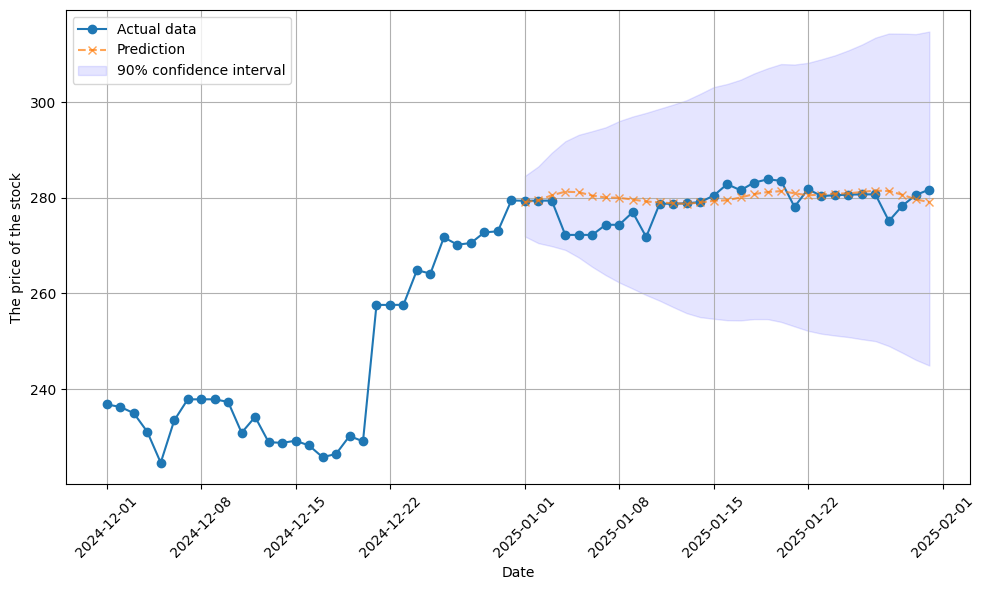

In [11]:
# Визуализация
plt.figure(figsize=(10, 6))

plt.plot(
    shown_timestamps,
    shown_values,
    label='Actual data',
    marker='o',
    linestyle='-'
)

# Строим прогноз (проверяем индекс предсказаний)
forecast_timestamps = predictions.index.get_level_values('timestamp')[:len(predicted_values)]
plt.plot(
    forecast_timestamps,
    predicted_values,
    label='Prediction',
    alpha=0.7,
    linestyle='--',
    marker='x'
)

# Визуализация интервалов
plt.fill_between(
    forecast_timestamps,
    forecast['0.1'],  # 10% квантиль
    forecast['0.9'],  # 90% квантиль
    alpha=0.1,
    color='b',
    label='90% confidence interval'
)

#plt.title('Chronos price forecast for noisy-free series (SBER)')
plt.xlabel('Date')
plt.ylabel('The price of the stock')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Поворот дат для удобства чтения
plt.tight_layout()
plt.show()